In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import joblib
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
# ---- Mount Drive ----
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/news.csv'
df = pd.read_csv(file_path)

In [4]:
print("✅ Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

✅ Dataset Shape: (6335, 4)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
None


In [5]:
df.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [7]:
print("\nMissing Values:\n", df.isna().sum())


Missing Values:
 Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


In [8]:
print("\nLabel Distribution:\n", df['label'].value_counts())


Label Distribution:
 label
REAL    3171
FAKE    3164
Name: count, dtype: int64


/tmp/ipython-input-3824352581.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='coolwarm')


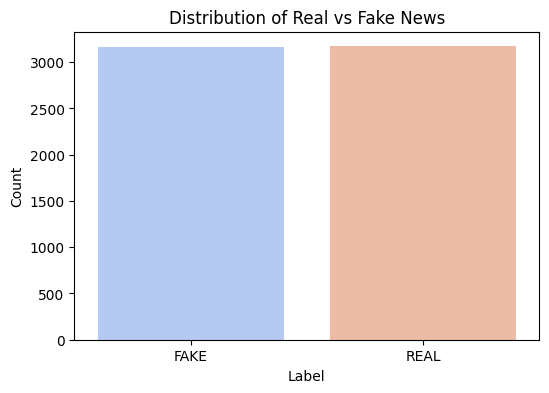

In [9]:
# ---- Visualize Label Distribution ----
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Distribution of Real vs Fake News")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

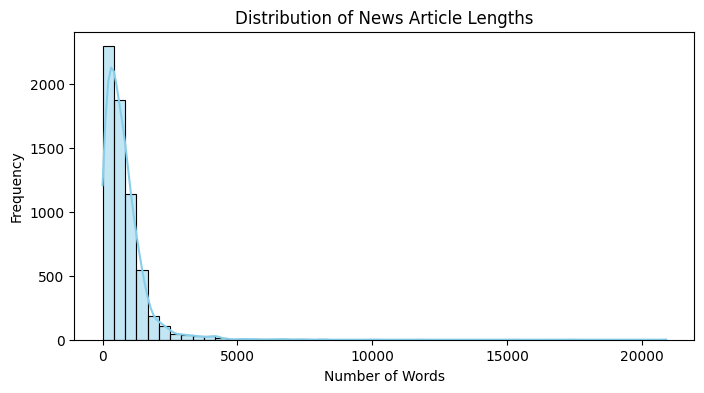

In [10]:
# ---- Add Text Length Column ----
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of News Article Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

In [11]:
print("\nSample Data:\n", df[['title', 'label']].head(5))


Sample Data:
                                                title label
0                       You Can Smell Hillary’s Fear  FAKE
1  Watch The Exact Moment Paul Ryan Committed Pol...  FAKE
2        Kerry to go to Paris in gesture of sympathy  REAL
3  Bernie supporters on Twitter erupt in anger ag...  FAKE
4   The Battle of New York: Why This Primary Matters  REAL


In [12]:
# ---- Combine title and text ----
df['content'] = df['title'] + " " + df['text']

# ---- Clean Text ----
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))   # remove non-alphabets
    text = text.lower()                           # lowercase
    text = text.split()                           # tokenize
    return " ".join(text)

df['clean_text'] = df['content'].apply(clean_text)

# ---- Encode Labels ----
label_encoder = LabelEncoder()
df['label_num'] = label_encoder.fit_transform(df['label'])  # FAKE=0, REAL=1

print("✅ Label Encoding done.")
print(df[['label', 'label_num']].drop_duplicates())

✅ Label Encoding done.
  label  label_num
0  FAKE          0
2  REAL          1


In [13]:
X = df['clean_text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Train-Test Split Complete.")
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

✅ Train-Test Split Complete.
Training samples: 5068
Testing samples: 1267


In [14]:
# ---- Tokenize ----
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [15]:
# ---- Pad Sequences ----
max_len = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f"✅ Vocabulary Size: {len(tokenizer.word_index)}")
print(f"✅ Max Sequence Length: {max_len}")

✅ Vocabulary Size: 60035
✅ Max Sequence Length: 300


In [16]:
# ---- Build Model ----
model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# ---- Compile Model ----
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# ---- Train ----
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    verbose=1
)

Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 151s 918ms/step - accuracy: 0.6101 - loss: 0.6538 - val_accuracy: 0.7048 - val_loss: 0.5918
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 198s 889ms/step - accuracy: 0.7344 - loss: 0.5511 - val_accuracy: 0.7522 - val_loss: 0.5705
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 143s 898ms/step - accuracy: 0.8218 - loss: 0.4323 - val_accuracy: 0.7324 - val_loss: 0.5536
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 202s 900ms/step - accuracy: 0.8645 - loss: 0.3223 - val_accuracy: 0.7530 - val_loss: 0.5637
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 147s 923ms/step - accuracy: 0.8905 - loss: 0.2526 - val_accuracy: 0.7269 - val_loss: 0.6920
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 144s 909ms/step - accuracy: 0.8982 - loss: 0.2249 - val_accuracy: 0.7198 - val_loss: 0.7444
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 145s 910ms/step - accuracy: 0.9154 - loss: 0.1867 - val_accuracy: 0.7537 - val_loss: 0.9246
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 144s 909ms/step - accuracy: 0.9265 -

In [18]:
# ---- Predict ----
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

# ---- Metrics ----
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n✅ Model Performance:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 380ms/step

✅ Model Performance:
Accuracy: 77.11%
Precision: 74.36%
Recall: 82.81%
F1-Score: 78.36%

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.71      0.76       633
           1       0.74      0.83      0.78       634

    accuracy                           0.77      1267
   macro avg       0.77      0.77      0.77      1267
weighted avg       0.77      0.77      0.77      1267


Confusion Matrix:
 [[452 181]
 [109 525]]


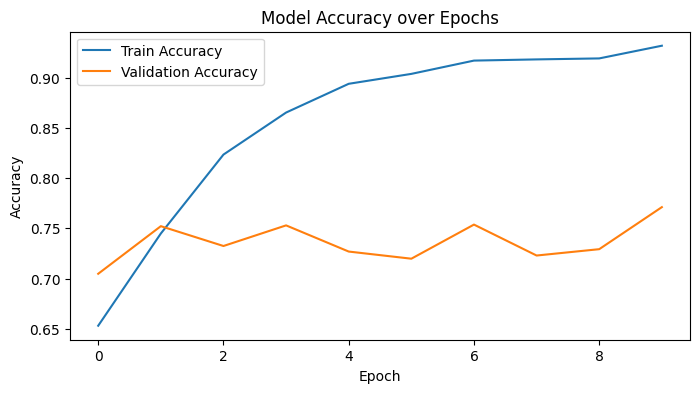

In [19]:
# Plot Accuracy ----
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


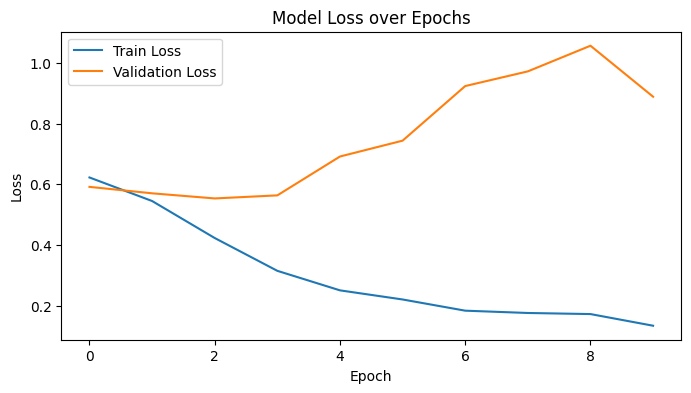

In [20]:
# ---- Plot Loss ----
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Save Model
model.save("/content/drive/MyDrive/fake_news_lstm_model.h5")

# Save Tokenizer
with open("/content/drive/MyDrive/fake_news_tokenizer.json", "w") as f:
    json.dump(tokenizer.to_json(), f)

# Save Label Encoder
joblib.dump(label_encoder, "/content/drive/MyDrive/label_encoder.pkl")

print("✅ Model, Tokenizer, and Label Encoder saved successfully!")

✅ Model, Tokenizer, and Label Encoder saved successfully!


In [22]:
def predict_news(news_text):
    clean = clean_text(news_text)
    seq = tokenizer.texts_to_sequences([clean])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = (model.predict(pad) > 0.5).astype("int32")
    label = label_encoder.inverse_transform(pred)[0]
    return label

# ---- Example ----
sample_news = "The government announced a new policy for renewable energy today."
print("📰 Prediction:", predict_news(sample_news))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
📰 Prediction: REAL


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
